In [8]:
from help_functions import download_and_unzip
import pandas as pd

download_and_unzip('https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip', 'getting_started.zip')

Beginning file download...


In [72]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [73]:
train_data.drop(columns = ['keyword', 'location', 'id'], inplace = True)
test_data.drop(columns = ['keyword', 'location', 'id'], inplace = True)

In [74]:
from sklearn.model_selection import train_test_split

features_train, features_val, labels_train, labels_val = train_test_split(train_data['text'].tolist(), 
                                                                            train_data['target'].tolist(), 
                                                                            test_size=0.2, 
                                                                            random_state=42)

In [75]:
import tensorflow as tf
train_data = tf.data.Dataset.from_tensor_slices((features_train, labels_train)).repeat(2).shuffle(500).batch(32).prefetch(tf.data.AUTOTUNE)
val_data = tf.data.Dataset.from_tensor_slices((features_val, labels_val)).batch(32)

In [76]:
for text, target in train_data.take(1):
    print(text[0].numpy())
    print(target[0].numpy())
    break

b'@NoahCRothman Bore him with minutiae serve bad champagne. He may just explode.'
0


In [77]:
textvectorizer = tf.keras.layers.TextVectorization(
    max_tokens=10000, standardize='lower_and_strip_punctuation',
    split='whitespace', ngrams=None, output_mode='int',
    output_sequence_length=15, pad_to_max_tokens=False)

textvectorizer.adapt(features_train)

In [78]:
textvectorizer(text[5])

<tf.Tensor: shape=(15,), dtype=int64, numpy=
array([   7,   31,  936, 4290,  100,  566,  695,  108,  208,    5, 3960,
        146, 1866,  423,   11], dtype=int64)>

In [20]:
embedding_layer = tf.keras.layers.Embedding(input_dim = 10000, 
                                            output_dim = 128, 
                                            embeddings_initializer='uniform', 
                                            input_length=15)


**DENSE LAYER MODEL**

In [21]:
from tensorflow.keras import layers
input = layers.Input(shape = (1,), dtype="string")
x = textvectorizer(input)
x = embedding_layer(x)
x = layers.GlobalAveragePooling1D()(x)
#x = tf.keras.layers.Dense(15, activation='relu')(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.Model(input, output, name = 'model_Dense_1')

In [23]:
model.compile(loss = 'binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

import datetime
log_dir = "Tensorboard/Dense_Layer_Exp/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [
             tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10 ** (epoch / 20), verbose=0),
             tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7),
              tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=5, 
                                              verbose=0),
              tf.keras.callbacks.ModelCheckpoint(
                  filepath='Models_checkpoints/Dense_Layer_Exp/model_ep_{epoch:02d}_val_accuracy_{val_accuracy:.4f}.ckpt',
                  # file path format: "Model_checkpoint_Classification_2/cp-{epoch:02d}-{val_loss:.02f}.ckpt"
                  save_weights_only=True,
                  verbose=0),
            tf.keras.callbacks.TensorBoard(log_dir=log_dir)
                ]

history = model.fit(train_data, 
                    epochs=5,
                    steps_per_epoch = len(train_data),
                    validation_data = val_data,
                    validation_steps = int(0.15*len(val_data)),
                    callbacks = callbacks)

Epoch 1/5
381/381 [==============================] - 6s 14ms/step - loss: 0.5496 - accuracy: 0.7731 - val_loss: 0.5748 - val_accuracy: 0.7455 - lr: 1.0000e-04
Epoch 2/5
381/381 [==============================] - 5s 13ms/step - loss: 0.5113 - accuracy: 0.7973 - val_loss: 0.5521 - val_accuracy: 0.7634 - lr: 1.1220e-04
Epoch 3/5
381/381 [==============================] - 5s 14ms/step - loss: 0.4723 - accuracy: 0.8158 - val_loss: 0.5321 - val_accuracy: 0.7545 - lr: 1.2589e-04
Epoch 4/5
381/381 [==============================] - 5s 13ms/step - loss: 0.4348 - accuracy: 0.8337 - val_loss: 0.5161 - val_accuracy: 0.7768 - lr: 1.4125e-04
Epoch 5/5
381/381 [==============================] - 5s 14ms/step - loss: 0.3994 - accuracy: 0.8502 - val_loss: 0.5040 - val_accuracy: 0.7857 - lr: 1.5849e-04


In [24]:
model.load_weights('Models_checkpoints\Dense_Layer_Exp\model_ep_05_val_accuracy_0.7857.ckpt')
history_01 = model.fit(train_data, 
                    initial_epoch = 4,
                    epochs=10,
                    steps_per_epoch = len(train_data),
                    validation_data = val_data,
                    validation_steps = int(0.15*len(val_data)),
                    callbacks = callbacks)

Epoch 5/10
381/381 [==============================] - 5s 13ms/step - loss: 0.3671 - accuracy: 0.8617 - val_loss: 0.4966 - val_accuracy: 0.7812 - lr: 1.5849e-04
Epoch 6/10
381/381 [==============================] - 5s 14ms/step - loss: 0.3378 - accuracy: 0.8731 - val_loss: 0.4924 - val_accuracy: 0.7857 - lr: 1.7783e-04
Epoch 7/10
381/381 [==============================] - 5s 13ms/step - loss: 0.3091 - accuracy: 0.8842 - val_loss: 0.4908 - val_accuracy: 0.7768 - lr: 1.9953e-04
Epoch 8/10
381/381 [==============================] - 5s 13ms/step - loss: 0.2810 - accuracy: 0.8977 - val_loss: 0.4921 - val_accuracy: 0.7723 - lr: 2.2387e-04
Epoch 9/10
379/381 [============================>.] - ETA: 0s - loss: 0.2535 - accuracy: 0.9115
Epoch 00009: ReduceLROnPlateau reducing learning rate to 5.023772828280926e-05.
381/381 [==============================] - 5s 13ms/step - loss: 0.2535 - accuracy: 0.9115 - val_loss: 0.4980 - val_accuracy: 0.7679 - lr: 2.5119e-04
Epoch 10/10
381/381 [==============

In [25]:
model.load_weights('Models_checkpoints\Dense_Layer_Exp\model_ep_06_val_accuracy_0.7857.ckpt')


In [26]:
model.evaluate(val_data)

48/48 [==============================] - 0s 1ms/step - loss: 0.4507 - accuracy: 0.8096


[0.4507176876068115, 0.8095863461494446]

In [27]:
preds = tf.round(tf.squeeze(model.predict(test_data))).numpy().tolist()

In [137]:
from sklearn.metrics import accuracy_score, precision_score, confusion_matrix, recall_score, f1_score

def matrices_calc(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    (tn, fp, fn, tp) = confusion_matrix(y_true, y_pred).ravel()
    #print(f'accuracy: {accuracy:.4f}\nPrecision: {precision:.4f}\nRecall: {recall}\nF1-Score: {f1:.4f}\n(tn, fp, fn, tp): {(tn, fp, fn, tp)}')
    metrics = {'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'F1-Score': f1,
                '(tn, fp, fn, tp)': (tn, fp, fn, tp)}
    return metrics

base_model_results = matrices_calc(labels_val, tf.round(tf.squeeze(model.predict(features_val))).numpy().tolist())
base_model_results

{'accuracy': 0.8003939592908733,
 'precision': 0.822429906542056,
 'recall': 0.6779661016949152,
 'F1-Score': 0.7432432432432432,
 '(tn, fp, fn, tp)': (779, 95, 209, 440)}

**LSTM LAYER MODEL**

In [41]:
embedding_layer = tf.keras.layers.Embedding(input_dim = 10000, 
                                            output_dim = 128, 
                                            embeddings_initializer='uniform', 
                                            input_length=15)

In [42]:
input = layers.Input(shape = (1,), dtype="string")
x = textvectorizer(input)
x = embedding_layer(x)
x = layers.LSTM(64)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_LSTM = tf.keras.Model(input, output, name = 'model_LSTM_1')

In [43]:
model_LSTM.compile(loss = 'binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

log_dir = "Tensorboard/LSTM_Layer_Exp/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [
             tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10 ** (epoch / 20), verbose=0),
             tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7),
              tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=5, 
                                              verbose=0),
              tf.keras.callbacks.ModelCheckpoint(
                  filepath='Models_checkpoints/LSTM_Layer_Exp/model_ep_{epoch:02d}_val_accuracy_{val_accuracy:.4f}.ckpt',
                  # file path format: "Model_checkpoint_Classification_2/cp-{epoch:02d}-{val_loss:.02f}.ckpt"
                  save_weights_only=True,
                  verbose=0),
            tf.keras.callbacks.TensorBoard(log_dir=log_dir)
                ]

history_LSTM = model_LSTM.fit(train_data, 
                    epochs=5,
                    steps_per_epoch = len(train_data),
                    validation_data = val_data,
                    validation_steps = int(0.15*len(val_data)),
                    callbacks = callbacks)

Epoch 1/5
381/381 [==============================] - 8s 17ms/step - loss: 0.5892 - accuracy: 0.6689 - val_loss: 0.5332 - val_accuracy: 0.7500 - lr: 1.0000e-04
Epoch 2/5
381/381 [==============================] - 7s 18ms/step - loss: 0.3157 - accuracy: 0.8722 - val_loss: 0.6005 - val_accuracy: 0.7054 - lr: 1.1220e-04
Epoch 3/5
380/381 [============================>.] - ETA: 0s - loss: 0.1984 - accuracy: 0.9308
Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.517850953154266e-05.
381/381 [==============================] - 6s 15ms/step - loss: 0.1982 - accuracy: 0.9310 - val_loss: 0.7464 - val_accuracy: 0.7054 - lr: 1.2589e-04
Epoch 4/5
381/381 [==============================] - 6s 17ms/step - loss: 0.1362 - accuracy: 0.9544 - val_loss: 0.8267 - val_accuracy: 0.7098 - lr: 1.4125e-04
Epoch 5/5
378/381 [============================>.] - ETA: 0s - loss: 0.1063 - accuracy: 0.9633
Epoch 00005: ReduceLROnPlateau reducing learning rate to 3.169786359649152e-05.
381/381 [===============

In [45]:
model_LSTM.load_weights('Models_checkpoints\LSTM_Layer_Exp\model_ep_05_val_accuracy_0.6964.ckpt')
model_LSTM.evaluate(val_data)

48/48 [==============================] - 0s 4ms/step - loss: 0.7857 - accuracy: 0.7597


[0.7857215404510498, 0.7596848607063293]

In [138]:
preds_LSTM = tf.round(tf.squeeze(model_LSTM.predict(test_data))).numpy().tolist()
LSTM_model_results = matrices_calc(labels_val, tf.round(tf.squeeze(model_LSTM.predict(features_val))).numpy().tolist())
LSTM_model_results

{'accuracy': 0.7596848325673013,
 'precision': 0.7140695915279879,
 'recall': 0.7272727272727273,
 'F1-Score': 0.7206106870229007,
 '(tn, fp, fn, tp)': (685, 189, 177, 472)}

**GRU LAYER MODEL**

In [47]:
embedding_layer = tf.keras.layers.Embedding(input_dim = 10000, 
                                            output_dim = 128, 
                                            embeddings_initializer='uniform', 
                                            input_length=15)


input = layers.Input(shape = (1,), dtype="string")
x = textvectorizer(input)
x = embedding_layer(x)
x = layers.GRU(64)(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_GRU = tf.keras.Model(input, output, name = 'model_GRU_1')

In [48]:
model_GRU.compile(loss = 'binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

log_dir = "Tensorboard/GRU_Layer_Exp/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [
             tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10 ** (epoch / 20), verbose=0),
             tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7),
              tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=5, 
                                              verbose=0),
              tf.keras.callbacks.ModelCheckpoint(
                  filepath='Models_checkpoints/GRU_Layer_Exp/model_ep_{epoch:02d}_val_accuracy_{val_accuracy:.4f}.ckpt',
                  # file path format: "Model_checkpoint_Classification_2/cp-{epoch:02d}-{val_loss:.02f}.ckpt"
                  save_weights_only=True,
                  verbose=0),
            tf.keras.callbacks.TensorBoard(log_dir=log_dir)
                ]

history_GRU = model_GRU.fit(train_data, 
                    epochs=5,
                    steps_per_epoch = len(train_data),
                    validation_data = val_data,
                    validation_steps = int(0.15*len(val_data)),
                    callbacks = callbacks)

Epoch 1/5
381/381 [==============================] - 8s 17ms/step - loss: 0.6585 - accuracy: 0.6014 - val_loss: 0.5889 - val_accuracy: 0.7545 - lr: 1.0000e-04
Epoch 2/5
381/381 [==============================] - 7s 18ms/step - loss: 0.3601 - accuracy: 0.8472 - val_loss: 0.5279 - val_accuracy: 0.7723 - lr: 1.1220e-04
Epoch 3/5
381/381 [==============================] - 7s 18ms/step - loss: 0.2068 - accuracy: 0.9196 - val_loss: 0.6428 - val_accuracy: 0.7500 - lr: 1.2589e-04
Epoch 4/5
380/381 [============================>.] - ETA: 0s - loss: 0.1317 - accuracy: 0.9516
Epoch 00004: ReduceLROnPlateau reducing learning rate to 2.825075061991811e-05.
381/381 [==============================] - 7s 17ms/step - loss: 0.1316 - accuracy: 0.9517 - val_loss: 0.8262 - val_accuracy: 0.7098 - lr: 1.4125e-04
Epoch 5/5
381/381 [==============================] - 7s 18ms/step - loss: 0.0966 - accuracy: 0.9662 - val_loss: 0.9826 - val_accuracy: 0.6964 - lr: 1.5849e-04


In [49]:
model_GRU.load_weights('Models_checkpoints\GRU_Layer_Exp\model_ep_05_val_accuracy_0.6964.ckpt')
model_GRU.evaluate(val_data)

48/48 [==============================] - 0s 2ms/step - loss: 0.8562 - accuracy: 0.7518


[0.856205403804779, 0.7518056631088257]

In [140]:
preds_GRU = tf.round(tf.squeeze(model_GRU.predict(test_data))).numpy().tolist()
GRU_model_results = matrices_calc(labels_val, tf.round(tf.squeeze(model_GRU.predict(features_val))).numpy().tolist())
GRU_model_results

{'accuracy': 0.7518056467498359,
 'precision': 0.6927453769559033,
 'recall': 0.7503852080123267,
 'F1-Score': 0.7204142011834321,
 '(tn, fp, fn, tp)': (658, 216, 162, 487)}

**BIDIRECTIONAL LAYER MODEL**

In [51]:
embedding_layer = tf.keras.layers.Embedding(input_dim = 10000, 
                                            output_dim = 128, 
                                            embeddings_initializer='uniform', 
                                            input_length=15)


input = layers.Input(shape = (1,), dtype="string")
x = textvectorizer(input)
x = embedding_layer(x)
x = layers.Bidirectional(layers.LSTM(64))(x)
output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

model_Bidirectional = tf.keras.Model(input, output, name = 'model_Bidirectional_1')

In [52]:
model_Bidirectional.compile(loss = 'binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])

log_dir = "Tensorboard/Bidirectional_Layer_Exp/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [
             tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10 ** (epoch / 20), verbose=0),
             tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7),
              tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=5, 
                                              verbose=0),
              tf.keras.callbacks.ModelCheckpoint(
                  filepath='Models_checkpoints/Bidirectional_Layer_Exp/model_ep_{epoch:02d}_val_accuracy_{val_accuracy:.4f}.ckpt',
                  # file path format: "Model_checkpoint_Classification_2/cp-{epoch:02d}-{val_loss:.02f}.ckpt"
                  save_weights_only=True,
                  verbose=0),
            tf.keras.callbacks.TensorBoard(log_dir=log_dir)
                ]

history_Bidirectional = model_Bidirectional.fit(train_data, 
                    epochs=5,
                    steps_per_epoch = len(train_data),
                    validation_data = val_data,
                    validation_steps = int(0.15*len(val_data)),
                    callbacks = callbacks)

Epoch 1/5
381/381 [==============================] - 12s 23ms/step - loss: 0.5938 - accuracy: 0.6644 - val_loss: 0.5104 - val_accuracy: 0.7589 - lr: 1.0000e-04
Epoch 2/5
381/381 [==============================] - 8s 21ms/step - loss: 0.2949 - accuracy: 0.8768 - val_loss: 0.5723 - val_accuracy: 0.7768 - lr: 1.1220e-04
Epoch 3/5
381/381 [==============================] - ETA: 0s - loss: 0.1640 - accuracy: 0.9414
Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.517850953154266e-05.
381/381 [==============================] - 8s 21ms/step - loss: 0.1640 - accuracy: 0.9414 - val_loss: 0.7504 - val_accuracy: 0.7188 - lr: 1.2589e-04
Epoch 4/5
381/381 [==============================] - 7s 19ms/step - loss: 0.1010 - accuracy: 0.9672 - val_loss: 0.8658 - val_accuracy: 0.7277 - lr: 1.4125e-04
Epoch 5/5
380/381 [============================>.] - ETA: 0s - loss: 0.0784 - accuracy: 0.9737
Epoch 00005: ReduceLROnPlateau reducing learning rate to 3.169786359649152e-05.
381/381 [==============

In [53]:
model_Bidirectional.load_weights('Models_checkpoints\Bidirectional_Layer_Exp\model_ep_05_val_accuracy_0.7098.ckpt')
model_Bidirectional.evaluate(val_data)

48/48 [==============================] - 0s 3ms/step - loss: 0.8118 - accuracy: 0.7689


[0.8118313550949097, 0.7688772082328796]

In [160]:
preds_Bidirectional = tf.round(tf.squeeze(model_Bidirectional.predict(test_data))).numpy().tolist()
Bidirectional_model_results = matrices_calc(labels_val, tf.round(tf.squeeze(model_Bidirectional.predict(features_val))).numpy().tolist())
Bidirectional_model_results

{'accuracy': 0.5292186474064347,
 'precision': 0.45792079207920794,
 'recall': 0.5701078582434514,
 'F1-Score': 0.5078929306794783,
 '(tn, fp, fn, tp)': (436, 438, 279, 370)}

**CNN LAYER MODEL**

In [84]:
embedding_layer = layers.Embedding(input_dim = 10000, 
                                    output_dim=128, 
                                    embeddings_initializer='uniform', 
                                    input_length=15)

input = layers.Input(shape = (1,), dtype = 'string')
x = textvectorizer(input)
x = embedding_layer(x)
x = layers.Conv1D(filters = 32, kernel_size = 5, activation = 'relu')(x)
x = layers.GlobalAveragePooling1D()(x)
output = layers.Dense(1, activation='sigmoid')(x)
model_CNN = tf.keras.Model(input, output, name = 'model_CNN')


# input = layers.Input(shape = (1,), dtype="string")
# x = textvectorizer(input)
# x = embedding_layer(x)
# x = layers.Bidirectional(layers.LSTM(64))(x)
# output = tf.keras.layers.Dense(1, activation='sigmoid')(x)

# model_Bidirectional = tf.keras.Model(input, output, name = 'model_Bidirectional_1')

In [87]:
model_CNN.compile(loss = 'binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
log_dir = "Tensorboard/CNN_Layer_Exp/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [
             tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10 ** (epoch / 20), verbose=0),
             tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7),
              tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=5, 
                                              verbose=0),
              tf.keras.callbacks.ModelCheckpoint(
                  filepath='Models_checkpoints/CNN_Layer_Exp/model_ep_{epoch:02d}_val_accuracy_{val_accuracy:.4f}.ckpt',
                  # file path format: "Model_checkpoint_Classification_2/cp-{epoch:02d}-{val_loss:.02f}.ckpt"
                  save_weights_only=True,
                  verbose=0),
            tf.keras.callbacks.TensorBoard(log_dir=log_dir)
                ]
history_CNN = model_CNN.fit(train_data,
                epochs = 5,
                steps_per_epoch = len(train_data),
                validation_data = val_data,
                validation_steps = int(0.15*len(val_data)),
                callbacks = callbacks)

Epoch 1/5
381/381 [==============================] - 6s 14ms/step - loss: 0.1486 - accuracy: 0.9516 - val_loss: 0.6537 - val_accuracy: 0.7188 - lr: 1.0000e-04
Epoch 2/5
381/381 [==============================] - 5s 14ms/step - loss: 0.1281 - accuracy: 0.9567 - val_loss: 0.7114 - val_accuracy: 0.7098 - lr: 1.1220e-04
Epoch 3/5
378/381 [============================>.] - ETA: 0s - loss: 0.1105 - accuracy: 0.9618
Epoch 00003: ReduceLROnPlateau reducing learning rate to 2.517850953154266e-05.
381/381 [==============================] - 5s 14ms/step - loss: 0.1103 - accuracy: 0.9619 - val_loss: 0.7747 - val_accuracy: 0.7143 - lr: 1.2589e-04
Epoch 4/5
381/381 [==============================] - 6s 15ms/step - loss: 0.0956 - accuracy: 0.9648 - val_loss: 0.8464 - val_accuracy: 0.7054 - lr: 1.4125e-04
Epoch 5/5
380/381 [============================>.] - ETA: 0s - loss: 0.0834 - accuracy: 0.9692
Epoch 00005: ReduceLROnPlateau reducing learning rate to 3.169786359649152e-05.
381/381 [===============

In [90]:
model_CNN.load_weights('Models_checkpoints\CNN_Layer_Exp\model_ep_05_val_accuracy_0.7098.ckpt')
model_CNN.evaluate(val_data)

48/48 [==============================] - 0s 2ms/step - loss: 0.7704 - accuracy: 0.7603


[0.7704440355300903, 0.7603414058685303]

In [155]:
preds_CNN = tf.round(tf.squeeze(model_CNN.predict(test_data))).numpy().tolist()
CNN_model_results = matrices_calc(labels_val, tf.round(tf.squeeze(model_CNN.predict(features_val))).numpy().tolist())
CNN_model_results

{'accuracy': 0.7603414313854235,
 'precision': 0.721183800623053,
 'recall': 0.7134052388289677,
 'F1-Score': 0.7172734314484895,
 '(tn, fp, fn, tp)': (695, 179, 186, 463)}

**Using Pretrained Embeddings (transfer learning for NLP)**

In [102]:
import tensorflow_hub as hub

embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")


In [103]:
embed_samples = embed(['I like to do NLP',
                      "When you call the universal sentence encoder on a sentence, it turns it into numbers."])

print(embed_samples[0])

tf.Tensor(
[ 0.05968354 -0.0160355  -0.02914821 -0.05212925  0.02219119 -0.04375772
 -0.02175827 -0.00285683  0.06052146  0.07888231  0.01754514 -0.00048307
 -0.00303452  0.03826183 -0.00717626 -0.066508    0.0197796  -0.07921368
 -0.05388004 -0.05932283 -0.03618991 -0.01079598 -0.05172737  0.03969066
 -0.08240779  0.07826601  0.06094696 -0.00315557  0.03758301 -0.01792064
  0.01135455  0.08448923 -0.02728054 -0.0094435  -0.00829289  0.05783823
 -0.01559617 -0.00373469 -0.06719187 -0.05175795  0.00120352  0.05621188
 -0.00547588  0.04713415  0.02688809  0.04525854 -0.02508668 -0.01137264
 -0.0354304   0.03592852 -0.04883497 -0.03299141 -0.04440108 -0.03241378
 -0.07060566  0.00464731  0.05392553  0.02533009 -0.01198686  0.02648442
 -0.05612548 -0.06441199  0.03217232  0.04579192 -0.01634137  0.03273923
 -0.05343557  0.01555051  0.02573398  0.00867869 -0.0112708   0.01323091
 -0.0399779  -0.03572034  0.01663027  0.00909084  0.02308734  0.03665894
  0.07215672  0.04339378  0.04741129  0.

In [112]:
# input = layers.Input(shape = (1,))
embedding_layer = hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                            input_shape = [],
                            dtype = 'string',
                            trainable = False,
                            name = 'USE')

model_USE = tf.keras.models.Sequential([
            embedding_layer,
            layers.Dense(64, activation='relu'),
            layers.Dense(1, activation='sigmoid')
])

In [114]:
model_USE.compile(loss = 'binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
log_dir = "Tensorboard/USE_Layer_Exp/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [
             tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10 ** (epoch / 20), verbose=0),
             tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7),
              tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=5, 
                                              verbose=0),
              tf.keras.callbacks.ModelCheckpoint(
                  filepath='Models_checkpoints/USE_Layer_Exp/model_ep_{epoch:02d}_val_accuracy_{val_accuracy:.4f}.ckpt',
                  # file path format: "Model_checkpoint_Classification_2/cp-{epoch:02d}-{val_loss:.02f}.ckpt"
                  save_weights_only=True,
                  verbose=0),
            tf.keras.callbacks.TensorBoard(log_dir=log_dir)]

history_USE = model_USE.fit(train_data,
                epochs = 5,
                steps_per_epoch = len(train_data),
                validation_data = val_data,
                validation_steps = int(0.15*len(val_data)),
                callbacks = callbacks)

Epoch 1/5
381/381 [==============================] - 7s 14ms/step - loss: 0.6442 - accuracy: 0.7318 - val_loss: 0.5888 - val_accuracy: 0.7946 - lr: 1.0000e-04
Epoch 2/5
381/381 [==============================] - 5s 12ms/step - loss: 0.5273 - accuracy: 0.7943 - val_loss: 0.4888 - val_accuracy: 0.8036 - lr: 1.1220e-04
Epoch 3/5
381/381 [==============================] - 4s 11ms/step - loss: 0.4603 - accuracy: 0.8028 - val_loss: 0.4437 - val_accuracy: 0.8036 - lr: 1.2589e-04
Epoch 4/5
381/381 [==============================] - 4s 12ms/step - loss: 0.4325 - accuracy: 0.8101 - val_loss: 0.4225 - val_accuracy: 0.8214 - lr: 1.4125e-04
Epoch 5/5
381/381 [==============================] - 6s 16ms/step - loss: 0.4180 - accuracy: 0.8151 - val_loss: 0.4107 - val_accuracy: 0.8348 - lr: 1.5849e-04


In [120]:
model_USE.load_weights('Models_checkpoints\\USE_Layer_Exp\model_ep_05_val_accuracy_0.8348.ckpt')


In [121]:
history_USE_1 = model_USE.fit(train_data,
                initial_epoch = 4,
                epochs = 10,
                steps_per_epoch = len(train_data),
                validation_data = val_data,
                validation_steps = int(0.15*len(val_data)),
                callbacks = callbacks)

Epoch 5/10
381/381 [==============================] - 6s 15ms/step - loss: 0.4089 - accuracy: 0.8209 - val_loss: 0.4048 - val_accuracy: 0.8304 - lr: 1.5849e-04
Epoch 6/10
381/381 [==============================] - 5s 14ms/step - loss: 0.4026 - accuracy: 0.8235 - val_loss: 0.4013 - val_accuracy: 0.8393 - lr: 1.7783e-04
Epoch 7/10
381/381 [==============================] - 5s 14ms/step - loss: 0.3973 - accuracy: 0.8259 - val_loss: 0.3985 - val_accuracy: 0.8348 - lr: 1.9953e-04
Epoch 8/10
381/381 [==============================] - 5s 14ms/step - loss: 0.3926 - accuracy: 0.8305 - val_loss: 0.3978 - val_accuracy: 0.8348 - lr: 2.2387e-04
Epoch 9/10
381/381 [==============================] - 5s 14ms/step - loss: 0.3885 - accuracy: 0.8320 - val_loss: 0.3965 - val_accuracy: 0.8304 - lr: 2.5119e-04
Epoch 10/10
381/381 [==============================] - 5s 14ms/step - loss: 0.3844 - accuracy: 0.8333 - val_loss: 0.3962 - val_accuracy: 0.8259 - lr: 2.8184e-04


In [122]:
model_USE.load_weights('Models_checkpoints\\USE_Layer_Exp\model_ep_06_val_accuracy_0.8393.ckpt')


In [171]:
print(model_USE.evaluate(val_data))
preds_USE = tf.round(tf.squeeze(model_USE.predict(test_data))).numpy().tolist()
USE_model_results = matrices_calc(labels_val, tf.round(tf.squeeze(model_USE.predict(features_val))).numpy().tolist())
USE_model_results

48/48 [==============================] - 0s 7ms/step - loss: 0.4130 - accuracy: 0.8168
[0.4129670262336731, 0.8168089389801025]


{'accuracy': 0.8168089297439265,
 'precision': 0.8052805280528053,
 'recall': 0.7519260400616333,
 'F1-Score': 0.7776892430278886,
 '(tn, fp, fn, tp)': (756, 118, 161, 488)}

**TRANSFERING ON 10% OF DATA**

In [129]:
feature_90, feature_10, label_90, label_10 = train_test_split(features_train, labels_train,
                                                            test_size=0.1,
                                                            random_state=42)

In [130]:
model_USE_10 = tf.keras.models.clone_model(model_USE)

In [132]:
model_USE_10.compile(loss = 'binary_crossentropy', optimizer=tf.keras.optimizers.Adam(), metrics=['accuracy'])
log_dir = "Tensorboard/USE_10_Layer_Exp/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
callbacks = [
             tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-4 * 10 ** (epoch / 20), verbose=0),
             tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
                                                 factor=0.2, # multiply the learning rate by 0.2 (reduce by 5x)
                                                 patience=2,
                                                 verbose=1, # print out when learning rate goes down 
                                                 min_lr=1e-7),
              tf.keras.callbacks.EarlyStopping(monitor='val_accuracy',
                                              patience=5, 
                                              verbose=0),
              tf.keras.callbacks.ModelCheckpoint(
                  filepath='Models_checkpoints/USE_10_Layer_Exp/model_ep_{epoch:02d}_val_accuracy_{val_accuracy:.4f}.ckpt',
                  # file path format: "Model_checkpoint_Classification_2/cp-{epoch:02d}-{val_loss:.02f}.ckpt"
                  save_weights_only=True,
                  verbose=0),
            tf.keras.callbacks.TensorBoard(log_dir=log_dir)]

history_USE_10 = model_USE_10.fit(feature_10, label_10,
                epochs = 5,
                #steps_per_epoch = len(train_data),
                validation_data = val_data,
                validation_steps = int(0.15*len(val_data)),
                callbacks = callbacks)

Epoch 1/5
20/20 [==============================] - 4s 136ms/step - loss: 0.4494 - accuracy: 0.7997 - val_loss: 0.4452 - val_accuracy: 0.8214 - lr: 1.0000e-04
Epoch 2/5
20/20 [==============================] - 2s 113ms/step - loss: 0.4468 - accuracy: 0.7997 - val_loss: 0.4445 - val_accuracy: 0.8214 - lr: 1.1220e-04
Epoch 3/5
20/20 [==============================] - 2s 115ms/step - loss: 0.4449 - accuracy: 0.7997 - val_loss: 0.4440 - val_accuracy: 0.8170 - lr: 1.2589e-04
Epoch 4/5
20/20 [==============================] - 2s 113ms/step - loss: 0.4427 - accuracy: 0.7997 - val_loss: 0.4430 - val_accuracy: 0.8214 - lr: 1.4125e-04
Epoch 5/5
20/20 [==============================] - 2s 111ms/step - loss: 0.4401 - accuracy: 0.8013 - val_loss: 0.4422 - val_accuracy: 0.8214 - lr: 1.5849e-04


In [144]:
model_USE_10.load_weights('Models_checkpoints\\USE_10_Layer_Exp\model_ep_05_val_accuracy_0.8214.ckpt')
print(model_USE_10.evaluate(val_data))
preds_USE_10 = tf.round(tf.squeeze(model_USE_10.predict(test_data))).numpy().tolist()
USE_10_results = matrices_calc(labels_val, tf.round(tf.squeeze(model_USE_10.predict(features_val))).numpy().tolist())
USE_10_results

48/48 [==============================] - 0s 8ms/step - loss: 0.4410 - accuracy: 0.8076
[0.4409676194190979, 0.8076165318489075]


{'accuracy': 0.8076165462902167,
 'precision': 0.7861736334405145,
 'recall': 0.7534668721109399,
 'F1-Score': 0.7694728560188828,
 '(tn, fp, fn, tp)': (741, 133, 160, 489)}

**Comparing all models**

In [157]:
import pandas as pd
all_model_results = pd.DataFrame({'base model': base_model_results,
                                    'LSTM model': LSTM_model_results,
                                    'GRU model': GRU_model_results,
                                    'Bidirectional model': Bidirectional_model_results,
                                    'CNN model': CNN_model_results,
                                    'USE model': USE_model_results,
                                    'USE 10% model': USE_10_results})
#all_model_results = all_model_results.transpose()
all_model_results

,base model,LSTM model,GRU model,Bidirectional model,CNN model,USE model,USE 10% model
accuracy,0.800394,0.759685,0.751806,0.529219,0.760341,0.816809,0.807617
precision,0.82243,0.71407,0.692745,0.457921,0.721184,0.805281,0.786174
recall,0.677966,0.727273,0.750385,0.570108,0.713405,0.751926,0.753467
F1-Score,0.743243,0.720611,0.720414,0.507893,0.717273,0.777689,0.769473
"(tn, fp, fn, tp)","(779, 95, 209, 440)","(685, 189, 177, 472)","(658, 216, 162, 487)","(436, 438, 279, 370)","(695, 179, 186, 463)","(756, 118, 161, 488)","(741, 133, 160, 489)"


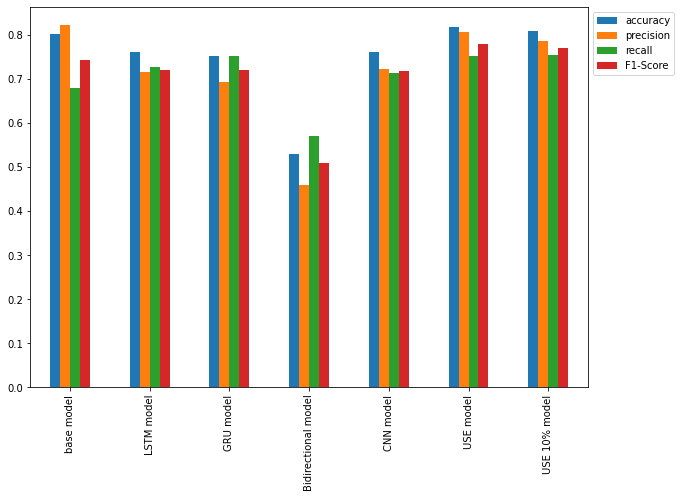

In [158]:
all_model_results.transpose().plot(kind="bar", figsize=(10, 7)).legend(bbox_to_anchor=(1.0, 1.0));


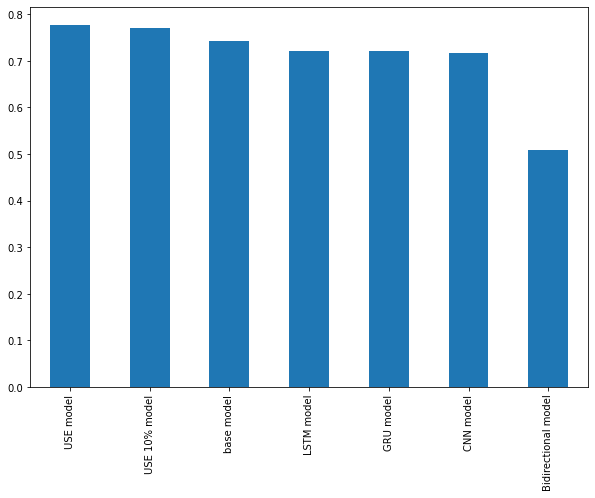

In [159]:
all_model_results.transpose().sort_values("F1-Score", ascending=False)["F1-Score"].plot(kind="bar", figsize=(10, 7));


In [183]:
import numpy as np
combined_preds = (np.array(preds) + np.array(preds_CNN) + np.array(preds_USE))//3

In [184]:
combined_preds

array([1., 0., 1., ..., 1., 0., 1.])

**Saving the hub model**

In [185]:
model_USE.save('model_USE.h5')

In [189]:
loaded_model = tf.keras.models.load_model("model_USE.h5", custom_objects={"KerasLayer": hub.KerasLayer})

In [190]:
predictions = loaded_model.predict(val_data)

In [222]:
pred_prob_lst = np.squeeze(predictions).tolist() # Prediction probability list

In [224]:
pos_idx_val_lst = [i for i, e in enumerate(labels_val) if e == 1] # index values of all the positives in the validation
neg_idx_val_lst = [i for i, e in enumerate(labels_val) if e == 0]

In [228]:
pos_val_pred_prob = [pred_prob_lst[i] for i in pos_idx_val_lst] # prediction probabilities of positives in validation set.
neg_val_pred_prob = [pred_prob_lst[i] for i in neg_idx_val_lst]

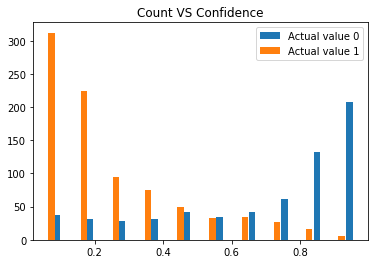

In [235]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(pos_val_pred_prob, rwidth=0.2, label = 'Actual value 0')
plt.hist(neg_val_pred_prob, rwidth=0.2, label = 'Actual value 1')
plt.title('Count VS Confidence')
plt.legend();
plt.show()